# Machine Learning and Statistics for Physicists

Material for a [UC Irvine](https://uci.edu/) course offered by the [Department of Physics and Astronomy](https://www.physics.uci.edu/).

Content is maintained on [github](github.com/dkirkby/MachineLearningStatistics) and distributed under a [BSD3 license](https://opensource.org/licenses/BSD-3-Clause).

##### &#9658; [View table of contents](Contents.ipynb)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

These are the PyTorch imports you will normally need:

In [2]:
import torch.nn
import torch.optim
import torch.utils.data

ModuleNotFoundError: No module named 'torch'

In [ ]:
import mls.torch

## Best Practices for Neural Networks

In the [previous notebook](https://nbviewer.jupyter.org/github/dkirkby/MachineLearningStatistics/blob/master/notebooks/NeuralNetworks.ipynb) we focused on the static building blocks used to create a neural network model. We now turn to the "dynamics" of learning to explain our data with the model.

The techniques described below are the current "best practices", but keep in mind that most do not have a solid theoretical basis and are justified by empirical studies on benchmark problems that might be quite different from your problem.

A good source for a deeper dive into these topics is [Improving Deep Neural Networks: Hyperparameter tuning, Regularization and Optimization](https://www.coursera.org/learn/deep-neural-network/home/welcome) on Coursera, which you can audit for free.

### Test Problem

We start by setting up a test problem that we will use throughout this notebook.

Our problem is to learn the function $y(x) = \sin(x)$ with samples of $x$ drawn from a uniform distribution on [-3,+3]. Create 1000 TRAIN samples and 100 TEST samples:

In [ ]:
torch.manual_seed(123)
x_train = 6 * torch.rand((1000, 1)) - 3
y_train = torch.sin(x_train)
x_test = 6 * torch.rand((100, 1)) - 3
y_test = torch.sin(x_test)
plt.plot(x_test.numpy(), y_test.numpy(), '.', label='TEST')
plt.legend();

Build a simple fully connected network with 1 input for $x$, 1 output for $y(x)$, and 2 hidden layers with 20 and 25 nodes:

In [ ]:
torch.manual_seed(123)
net = torch.nn.Sequential(
    torch.nn.Linear(1, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 25),
    torch.nn.ReLU(),
    torch.nn.Linear(25, 1),
)

**EXERCISE:** How many parameters does this model have?  Compare with the size of our training dataset. What are the model's hyperparameters?

**ANSWER:** Each layer has $(n_\text{in} + 1) n_\text{out}$ parameters, so the total number is:

In [ ]:
2 * 20 + 21 * 25 + 26 * 1

We can query the model directly for details about its parameters:

In [ ]:
{n: theta.shape for n, theta in net.named_parameters()}

In [ ]:
np.sum([np.prod(theta.shape) for theta in net.parameters()])

Since there are almost as many parameters (591) as training data values (1000), there is a real danger of "overfitting" (memorizing the training data). Note that a polynomial model with only 4 (carefully chosen) parameters does an excellent job of "learning" $y(x) = \sin(x)$:

In [ ]:
simple_model = lambda x: x - x ** 3 / 6 + x ** 5 / 120 - x ** 7 / 5040
y_pred = simple_model(x_test)
plt.plot(x_test.numpy(), y_pred.numpy(), '.', label='4-param model')
plt.legend()

This model has no explicit numerical hyperparameters, but its entire architecture is an arbitrary choice that we do not learn from the data. Therefore, we should really consider the number of hidden layers, nodes per hidden layer, and choice of activation function as "hyperparameters".

---

Our choice of ReLU activation is fairly arbitrary here (since other activations would also work). We do not use any activation on the final outputs since this is a regression problem (although a Tanh activation could work in this example since our output range is [-1, +1]).

Save the initial state of the network so we can restore it before each of our learning experiments below (details [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference)):

In [ ]:
torch.save(net.state_dict(), 'net.pth')

Finally, define the [loss function](https://pytorch.org/docs/stable/nn.html#mseloss) we will use throughout:

In [ ]:
loss_fn = torch.nn.MSELoss()

Since our network is initialized with random weights, its initial prediction is completely wrong:

In [ ]:
y_pred = net(x_test).detach()
plt.plot(x_test.numpy(), y_pred.numpy(), 'k.');
plt.plot(x_test.numpy(), y_test.numpy(), 'r.');

However, our prediction is still a smooth (and differentiable) function of $x$, by construction!

### Training Loop

Train the network for 200 "epochs" (one full pass through the training data) using [stochastic gradient descent (SGD)](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD) to update the parameters after each epoch. The parameter update rule is:
$$
\theta_k \rightarrow \theta_k - \eta \dot{\theta}_k
$$
but with a new [momentum hyperparameter](http://ruder.io/optimizing-gradient-descent/) $\rho$ which smooths out the estimated gradient over many cycles:
$$
\dot{\theta}_k \rightarrow \frac{\partial\ell}{\partial\theta_k} + \rho \dot{\theta}_k \; .
$$
With $\rho = 0$, this reduces to the simpler SGD rule we used earlier.

In [ ]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

Here is the standard PyTorch training and test loop that we will build on below:

In [ ]:
torch.manual_seed(123)
net.load_state_dict(torch.load('net.pth'))
losses_train, losses_test = [], []
for epoch in range(200):
    # Calculate the loss on the training sample.
    net.train() # configure the model for training
    y_pred = net(x_train)
    loss = loss_fn(y_pred, y_train)
    # Update the parameters.
    optimizer.zero_grad()
    loss.backward()
    #take the current values of the params and update them according to learning
    #rate and momentum
    optimizer.step() 
    # Save the training loss after each epoch.
    losses_train.append(loss.data)
    # Calculate and save the test loss after each epoch.
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test)
    losses_test.append(loss_fn(y_pred, y_test).data)
plt.plot(losses_train, '.', label='TRAIN')
plt.plot(losses_test, '.', label='TEST')
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log');

The plot above compares the TRAIN and TEST losses (on a log scale) after each epoch of training. They track each other well which indicates that our learned model has not simply memorized the training data. The change in (log) slope after ~100 epochs indicates that there is not much benefit in going much beyond 200 epochs with the current training loop.

Plot the final predictions for the TEST data, which look great:

In [ ]:
net.eval()
y_pred = net(x_test).detach()
plt.plot(x_test.numpy(), y_pred.numpy(), 'b.', ms=10);
plt.plot(x_test.numpy(), y_test.numpy(), 'rx');

The typical error in $y$ is ~0.01, which we could have predicted from the final loss ~1e-4 shown above:

In [ ]:
dy = (y_pred - y_test).reshape(-1).numpy()
plt.hist(dy, bins=20)
print(f'std(dy) = {np.std(dy):.3f}.')
print(f'MSE = mean(dy ** 2) = {np.mean(dy ** 2):.5f}.')

### Preprocessing

Our input data is uniformly distributed on [-3,+3], which works well for this learning problem:

In [ ]:
plt.hist(x_train.reshape(-1));

However, the ability to learn a model can be quite sensitive to the input distribution. To demonstrate this, compare learning with different linear transformations applied to $x$:

In [ ]:
variations = {'x': x_train, '2x': 2 * x_train, 'x+3': x_train + 3}

In [ ]:
torch.manual_seed(123)
net.train()
for label, x in variations.items():
    optimizer.load_state_dict(torch.load('opt.pth'))
    net.load_state_dict(torch.load('net.pth'))
    losses = []
    for epoch in range(200):
        y_pred = net(x)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_train)
        losses.append(loss.data)
        loss.backward()
        optimizer.step()
    plt.plot(losses, '.', label=label)
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log');

Note how seemingly trivial changes to the input data drastically impact our ability to learn the model!

The reason for this behavior is that individual modules have a range that their input distribution needs to cover for efficient learning. This is clearest for activation modules that saturate outside a narrow range centered on zero: they need inputs roughly centered on zero with enough samples probing their non-linearity but not too many samples saturating.  A nice feature of ReLU is that it is scale invariant, although it still expects a distribution centered near zero (since it is not translation invariant).

The case of linear modules is more subtle since they are mathematically degenerate with a linear transform of their inputs. However, they still set an effective scale through the distribution of their initial random weights and biases.

The histograms below follow the input distribution through the first layer to show how the network responds differently in each case:

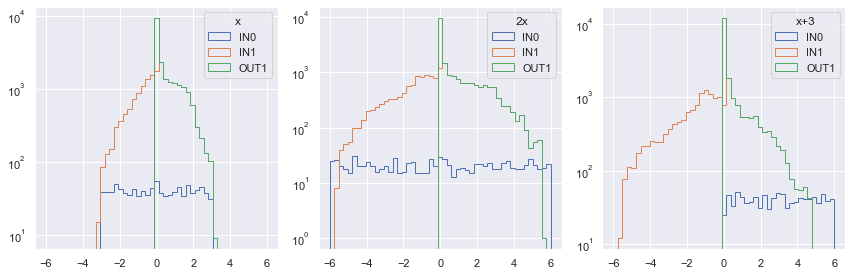

In [20]:
torch.manual_seed(123)
net.load_state_dict(torch.load('net.pth'))
mls.torch.trace(net, True)
bins = np.linspace(-6, 6, 50)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, (label, x) in enumerate(variations.items()):
    y_pred = net(x)
    ax = axes[i]
    ax.hist(net[0].input.reshape(-1), bins=bins, histtype='step', label='IN0')
    ax.hist(net[1].input.reshape(-1), bins=bins, histtype='step', label='IN1')
    ax.hist(net[1].output.reshape(-1), bins=bins, histtype='step', label='OUT1')
    ax.legend(title=label)
    ax.set_yscale('log')
plt.tight_layout()
mls.torch.trace(net, False)

The solution to this problem is to carefully preprocess your network inputs to ensure that they flow "smoothly" (i.e., without saturation) through your initial layer.  PyTorch does not provide utilities for this, but [sklearn.preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html) is a good starting point.

An alternative approach would be carefully tune the distribution of initial random Linear parameters, but preprocessing your inputs is the standard and simpler approach.

We will see below that it can also be useful to standardize the distribution of hidden node values (aka "BatchNorm").

### Minibatch Training

Recall that **stochastic** gradient descent involves performing parameter updates on random subsets of your data, known as "minibatches", rather than the whole data (as we did above).  We now have the tools to study the tradeoffs when choosing the batch size hyperparameter value.

PyTorch provides [convenient utilities](https://pytorch.org/docs/stable/data.html) for wrapping your training data tensors into a "minibatch factory":

In [21]:
xy_train = torch.utils.data.TensorDataset(x_train, y_train)
loader = torch.utils.data.DataLoader(xy_train, batch_size=5, shuffle=True)

We use the standard python iterator syntax to perform a random pass through the full data (one "epoch"):

In [22]:
for batch_num, (x_batch, y_batch) in enumerate(loader):
    if batch_num < 2 or batch_num >= len(loader) - 2:
        print(f'BATCH {batch_num}:\n  x_batch[:,0] = {x_batch[:,0]}\n  y_batch[:,0] = {y_batch[:,0]}.')
    elif batch_num == 2:
        print('\n...\n')

BATCH 0:
  x_batch[:,0] = tensor([ 0.2595,  2.6137,  1.3224,  2.1310, -1.8430])
  y_batch[:,0] = tensor([ 0.2566,  0.5037,  0.9693,  0.8471, -0.9632]).
BATCH 1:
  x_batch[:,0] = tensor([2.6128, 2.4146, 1.7817, 2.1530, 1.1425])
  y_batch[:,0] = tensor([0.5045, 0.6647, 0.9778, 0.8353, 0.9097]).

...

BATCH 198:
  x_batch[:,0] = tensor([-2.3623,  0.5899,  0.9353, -2.8777,  1.7667])
  y_batch[:,0] = tensor([-0.7028,  0.5562,  0.8048, -0.2608,  0.9809]).
BATCH 199:
  x_batch[:,0] = tensor([-2.8350,  2.9135,  2.8679,  0.9135, -1.2125])
  y_batch[:,0] = tensor([-0.3018,  0.2261,  0.2703,  0.7916, -0.9365]).


Update our training loop to use a `loader` and try different batch size values.  Note that the learning rate should generally be adjusted when changing the batch size: with less data used for an update, we are less confident in how much to change the parameters and so want a correspondingly smaller step size (learning rate).

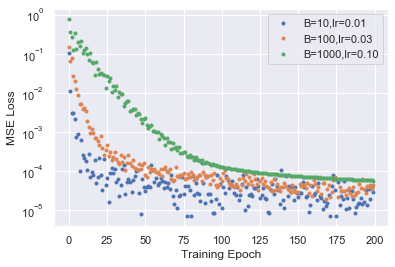

In [23]:
torch.manual_seed(123)
net.train()
for batch_size, learning_rate in zip((10, 100, 1000), (0.01, 0.03, 0.1)):
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    net.load_state_dict(torch.load('net.pth'))
    loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)
    losses = []
    for epoch in range(200):
        for x_batch, y_batch in loader:
            y_pred = net(x_batch)
            optimizer.zero_grad()
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        losses.append(loss.data)
    plt.plot(losses, '.', label=f'B={batch_size},lr={learning_rate:.2f}')
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log');

Note that the smallest batch size learns fastest but is also very noisy. At the other extreme, putting all the data into a single big batch has a relatively smooth loss curve, but takes much longer to learn the data.

In general, you should break your data into minibatches and the batchsize is yet another hyperparameter that you will need to choose carefully.

### Learning Rate Optimization

We discussed above how learning rate should be adjusted when tuning the batch size, but how do you find the "best" learning rate for a fixed batch size?
 
We will start by running a study of learning progress (measured by the loss curve) for a fixed batch size of 200 (which might not be optimal, but gives less noisy loss curves) and varying learning rate:

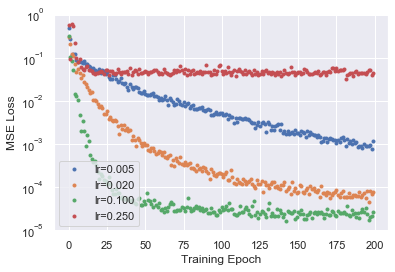

In [24]:
torch.manual_seed(123)
net.train()
loader = torch.utils.data.DataLoader(xy_train, batch_size=200, shuffle=True)
for learning_rate in (0.005, 0.02, 0.1, 0.25):
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    net.load_state_dict(torch.load('net.pth'))
    losses = []
    for epoch in range(200):
        for x_batch, y_batch in loader:
            y_pred = net(x_batch)
            optimizer.zero_grad()
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        losses.append(loss.data)
    plt.plot(losses, '.', label=f'lr={learning_rate:.3f}')
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log');

Note how the learning progress depends very non-linearly on the learning rate: the best (0.10) and worst (0.25) learning rates are relatively similar!  You should always study your loss curve and look for the features demonstrated in this example:
 - $\eta = 0.005$: Learning is slow and steady and appears ~linear on this log scale (after some initial rapid progress). This type of curve generally means you can safely increase your learning rate by a factor of ~10.
 - $\eta = 0.02$: Learning is proceeding well but slowing down after 200 epochs. If this is the best loss curve you can achieve after 200 epochs, just keep going for more epochs.
 - $\eta = 0.1$: Most of the learning happened in the first ~50 epochs, then essentially no more progress. If the plateau level gives acceptable performance (on both the TRAIN and TEST samples), then you only need to train for 50 epochs in future.
 - $\eta = 0.25$: After some initial rapid progress, the network gets "stuck" in a bad state where it can no longer learn with additional training epochs. This is a clear sign that your learning rate is too large.
 
Note that we are focusing here on the TRAIN loss curve since learning the training data is a necessary (but not sufficient) condition.  However, remember to check that your final chosen learning rate has a similar TEST loss curve, to ensure good generalization.

---

There have been some important new developments in optimizing learning rates. A good starting point is these papers:
 - [Smith 2018 "A disciplined approach to neural network hyper-parameters"](https://arxiv.org/pdf/1803.09820.pdf)
 - [Smith 2015 "Cyclical Learning Rates for Training Neural Networks"](https://arxiv.org/abs/1506.01186)

The first idea is that you do not need to repeat a full training loop to study each possible learning rate. Instead, you can often get away with increasing your learning rate on the fly, after each minibatch update to your parameters, using logarithmic steps.

This technique is not (yet) implemented in PyTorch, but is implemented in the useful [fastai library](https://docs.fast.ai/) and also as `mls.torch.lr_scan`. To run a study, we provide a data loader, a model, a loss function, and the optimizer to use:

Recommended lr=0.0588.


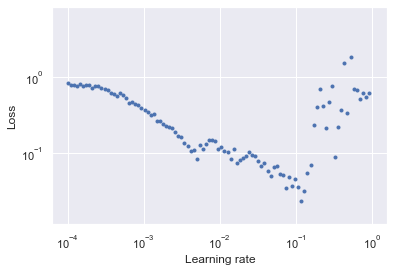

In [25]:
torch.manual_seed(123)
loader = torch.utils.data.DataLoader(xy_train, batch_size=200, shuffle=True)
net.load_state_dict(torch.load('net.pth'))
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
mls.torch.lr_scan(loader, net, loss_fn, optimizer, lr_start=1e-4, lr_stop=1.)

The scan results are noisy, but clearly show an optimum learning rate somewhere near 0.1. Note that approach allows us to scan a wide range of learning rates with much less computation than the brute force study above.

---

The next technique is adjust the learning rate each epoch according to some predetermined "schedule". Cyclic learning rates have been associated with "superconvergence", i.e., must faster learning than a fixed learning rate, but your mileage may vary.

Compare some different schedules that we can easily implement using [torch.optim.lr_scheduler](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate), including a custom [1-cycle policy](https://medium.com/@nachiket.tanksale/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) schedule:

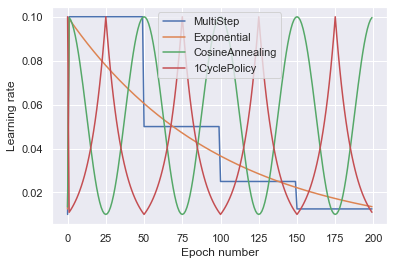

In [38]:
def OneCyclePolicy(epoch, period=50, frac=0.1):
    phase = (epoch % period) / period
    gamma = frac ** (-2 / period)
    #print(phase, gamma)
    if phase < 0.5:
        return frac * gamma ** (period * phase)
    else:
        return frac * gamma ** (period * (1 - phase))

optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
schedulers = {
    'MultiStep': torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100, 150], gamma=0.5),
    'Exponential': torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99),
    'CosineAnnealing': torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min=0.01),
    '1CyclePolicy': torch.optim.lr_scheduler.LambdaLR(optimizer, OneCyclePolicy),
}
for name, scheduler in schedulers.items():
    rate = []
    for epoch in range(200):
        rate.append(optimizer.get_lr())
        scheduler.step()
    plt.plot(rate, '-', label=name)
plt.legend()
plt.xlabel('Epoch number')
plt.ylabel('Learning rate');

### Data Augmentation

To motivate the need for our next technique, imagine that we have a very small training set (compared with the number of parameters we wish to learn) of only 25 samples:

In [27]:
x_sparse = x_train[:25]
y_sparse = y_train[:25]

Not surprisingly, the network learns to memorize the 25 samples with its 591 parameters, as we can demonstrate by comparing the TRAIN and TEST loss curves. Note that we train for 1000 epochs here since there are only 25 samples per epoch:

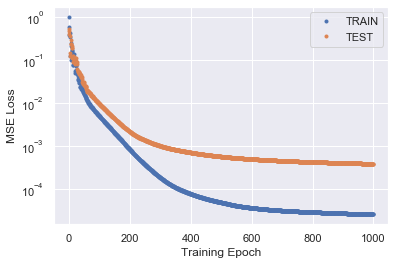

In [28]:
torch.manual_seed(123)
optimizer = torch.optim.SGD(net.parameters(), lr=0.03, momentum=0.9)
net.load_state_dict(torch.load('net.pth'))
losses_train, losses_test = [], []
for epoch in range(1000):
    net.train()
    y_pred = net(x_sparse)
    loss = loss_fn(y_pred, y_sparse)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses_train.append(loss.data)
    net.eval()
    y_pred = net(x_test)
    losses_test.append(loss_fn(y_pred, y_test).data)
plt.plot(losses_train, '.', label='TRAIN')
plt.plot(losses_test, '.', label='TEST')
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log');

In cases like this your best option is to include more data, but this is not always possible. Your next-best option is to reduce the complexity (number of parameters) of your model, with fewer layers and/or hidden nodes.

However, there is a third option that can help prevent memorization, called "data augmentation". The idea is to replace each of your input samples with a group of similar (but not identical) augmented samples. There are two general strategies for augmentation:
 - Exploit (approximate) symmetries in your data. For example, if we know the function we are trying to learn is even, $f(-x) = -f(x)$, we can augment each input sample $(x_i, y_i)$ with its mirror partner $(-x_i, -y_i)$. Perhaps it would be better to use a model with the appropriate symmetries built in but this is often not straightforward (especially with neural networks), so we instead symmetrize the input data to (approximately) symmetrize the model's predictions.
 - Perturb or distort each input sample to produce some equally plausible input samples. Selecting suitable perturbations requires some assumptions about the (unknown) distribution that the input data is drawn from, but small perturbations are generally safe.

In our example of learning $x\rightarrow y = \sin(x)$, we augment each sample using even symmetry:

In [29]:
# Add (-x, -y) for each (x, y).
x_augmented = torch.cat((x_sparse, -x_sparse))
y_augmented = torch.cat((y_sparse, -y_sparse))

In this plot, the original samples are drawn as circles, and the augmented samples are red dots:

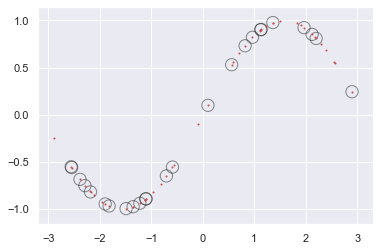

In [30]:
plt.plot(x_augmented.numpy(), y_augmented.numpy(), 'r.', ms=2);
plt.scatter(x_sparse.numpy(), y_sparse.numpy(), s=150, facecolors='none', edgecolors='k', alpha=0.5);

Train with this augmented data and compare the TRAIN and TEST performance:

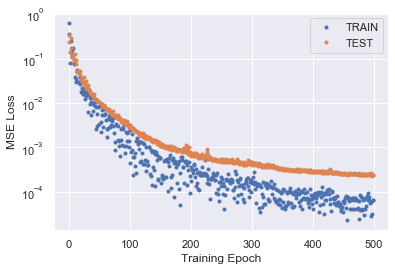

In [31]:
xy_augmented = torch.utils.data.TensorDataset(x_augmented, y_augmented)
loader = torch.utils.data.DataLoader(xy_augmented, batch_size=25, shuffle=True)
torch.manual_seed(123)
optimizer = torch.optim.SGD(net.parameters(), lr=0.03, momentum=0.9)
net.load_state_dict(torch.load('net.pth'))
losses_train, losses_test = [], []
for epoch in range(500):
    net.train()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses_train.append(loss.data)
    net.eval()
    y_pred = net(x_test)
    losses_test.append(loss_fn(y_pred, y_test).data)    
plt.plot(losses_train, '.', label='TRAIN')
plt.plot(losses_test, '.', label='TEST')
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log');

Augmentations can also be applied by mixing pairs of input samples or applying augmentations to inner layers rather than input features. See [this paper](https://arxiv.org/abs/2002.11102) for some recent developments.

**EXERCISE:** Identify some potentially useful data augmentations for (grayscale) image data.

### Dropout

Another approach for improving generalization with a small training dataset is called "dropout", which is implemented (in PyTorch) as a [DropOut module](https://pytorch.org/docs/stable/nn.html#dropout) that randomly zeros a preset fraction of its inputs, effectively turning them off for a single minibatch, and forcing the network to try and compensate with the remaining input values.

Using dropout in training is similar to training an ensemble of networks with slightly different architectures and building a consensus output, similar to the design of a random forest of decision trees. Dropout can also be used to estimate the Bayesian uncertainty of a network prediction (see [this 2015 paper](https://arxiv.org/abs/1506.02142) for details).

To introduce dropout, we rebuild our network with two Dropout modules that each zero just 1% of their inputs. Dropout is [usually](https://sebastianraschka.com/faq/docs/dropout-activation.html) applied right after an activation module:

In [32]:
torch.manual_seed(123)
dropout_net = torch.nn.Sequential(
    torch.nn.Linear(1, 20),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.01),
    torch.nn.Linear(20, 25),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.01),
    torch.nn.Linear(25, 1),
)
torch.save(dropout_net.state_dict(), 'dropout_net.pth')

Repeat our earlier learning loop on the sparse data using the new model with dropout:

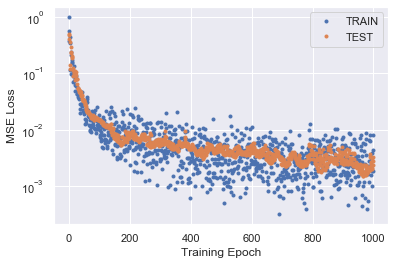

In [33]:
torch.manual_seed(123)
optimizer = torch.optim.SGD(dropout_net.parameters(), lr=0.03, momentum=0.9)
dropout_net.load_state_dict(torch.load('dropout_net.pth'))
losses_train, losses_test = [], []
for epoch in range(1000):
    dropout_net.train()
    y_pred = dropout_net(x_sparse)
    loss = loss_fn(y_pred, y_sparse)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses_train.append(loss.data)
    dropout_net.eval()
    y_pred = dropout_net(x_test)
    losses_test.append(loss_fn(y_pred, y_test).data)
plt.plot(losses_train, '.', label='TRAIN')
plt.plot(losses_test, '.', label='TEST')
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log');

Note how dropout has a comparable effect on the loss curves to our data augmentation above. Since these methods achieve their results with different approaches, they can be combined.

Also note that the TEST curve is much smoother: this is because we disable the dropout when testing using the model's [eval method](https://pytorch.org/docs/stable/nn.html#torch.nn.Module.eval). (There is a corresponding [train method](https://pytorch.org/docs/stable/nn.html#torch.nn.Module.train) to allow you to switch between TRAIN/TEST modes.)

The fixed dropout rates used by each module are yet more hyperparameters that needed to be chosen carefully. To see the impact of a poor choice in this problem, try 50% (which is often recommended as a good default):

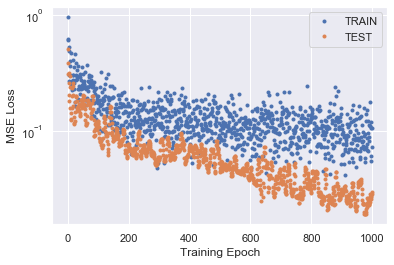

In [34]:
dropout_net = torch.nn.Sequential(
    torch.nn.Linear(1, 20),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(20, 25),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(25, 1),
)
torch.manual_seed(123)
optimizer = torch.optim.SGD(dropout_net.parameters(), lr=0.03, momentum=0.9)
dropout_net.load_state_dict(torch.load('dropout_net.pth'))
losses_train, losses_test = [], []
for epoch in range(1000):
    dropout_net.train()
    y_pred = dropout_net(x_sparse)
    loss = loss_fn(y_pred, y_sparse)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses_train.append(loss.data)
    dropout_net.eval()
    y_pred = dropout_net(x_test)
    losses_test.append(loss_fn(y_pred, y_test).data)
plt.plot(losses_train, '.', label='TRAIN')
plt.plot(losses_test, '.', label='TEST')
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log');

### BatchNorm

Our last technique is (mini)batch norm(alization) or just "BatchNorm". The idea is to get the benefits of preprocessing but for the inputs to hidden layers, and not just the input layer. See the [original 2015 paper](https://arxiv.org/abs/1502.03167) for details.

Normalizing in this case means applying a linear transformation to each input node so that it has a mean of zero and variance of one,
$$
x' = \frac{x - \mu_x}{\sqrt{\sigma_x^2 + \epsilon}} \; ,
$$
where $\mu_x$ and $\sigma_x$ are measured on each minibatch and $\epsilon \simeq 10^{-5}$ is added for numerical stability when $\sigma_x \simeq 0$.  Note that calculating $\mu_x$ and $\sigma_x$ on minibatches, rather than the whole sample, introduces some noise (more for smaller batch sizes) that can improve generalization: this is a recurring theme that we have already met in SGD, data augmentation and dropout.

A clever refinement to the basic BatchNorm is to take the standardized $x'$ and shift it to a new mean $\beta$ and variance $\gamma$ (for each input),
$$
x'' = \gamma x' + \beta \; ,
$$
where now $\gamma$ and $\beta$ are learnable (per-input) parameters of the model. BatchNorm is usually applied **before** an activation module (unlike dropout). Since our network has a `Linear` module before each activation, the linear bias is now degenerate with the $\beta$ parameter, so should be omitted using `bias=False`.

Just as with dropout, we need to rebuild our network to include BatchNorm:

In [35]:
torch.manual_seed(123)
batchnorm_net = torch.nn.Sequential(
    torch.nn.Linear(1, 20, bias=False),
    torch.nn.BatchNorm1d(20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 25, bias=False),
    torch.nn.BatchNorm1d(25),
    torch.nn.ReLU(),
    torch.nn.Linear(25, 1),
)
torch.save(batchnorm_net.state_dict(), 'batchnorm_net.pth')

In this example, we find that adding BatchNorm significantly degrades the learning performance with a "good" batch size of 200 and learning rate of 0.1, presumably because the relatively small tensors in this problem have large fluctuations in the mean and variance estimate on each minibatch:

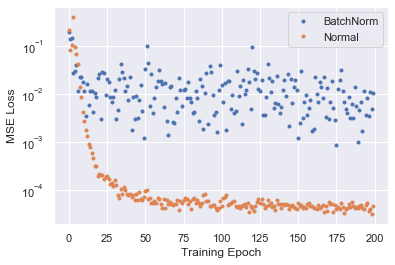

In [36]:
torch.manual_seed(123)
for name, model_name in (('BatchNorm', 'batchnorm_net'), ('Normal', 'net')):
    model = eval(model_name)
    model.load_state_dict(torch.load(f'{model_name}.pth'))
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    model.train()
    losses = []
    loader = torch.utils.data.DataLoader(xy_train, batch_size=200, shuffle=True)
    for epoch in range(200):
        for x_batch, y_batch in loader:
            y_pred = model(x_batch)
            optimizer.zero_grad()
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        losses.append(loss.data)
    plt.plot(losses, '.', label=name)
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log');

We can at least verify that BatchNorm does not do too much harm with a larger batch size (1000 instead of 200):

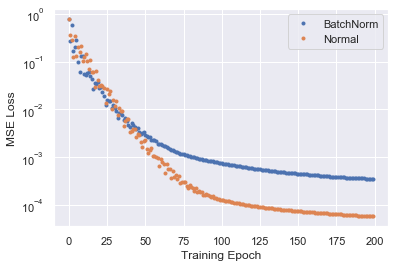

In [37]:
torch.manual_seed(123)
for name, model_name in (('BatchNorm', 'batchnorm_net'), ('Normal', 'net')):
    model = eval(model_name)
    model.load_state_dict(torch.load(f'{model_name}.pth'))
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    model.train()
    losses = []
    loader = torch.utils.data.DataLoader(xy_train, batch_size=1000, shuffle=True)
    for epoch in range(200):
        for x_batch, y_batch in loader:
            y_pred = model(x_batch)
            optimizer.zero_grad()
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        losses.append(loss.data)
    plt.plot(losses, '.', label=name)
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log');

BatchNorm is considered essential for many of the cutting edge architectures, but these are much deeper and wider than our simple problem. The lesson is that you should not assume that cutting edge techniques will benefit your (likely simpler) problem!